In [1]:
# データ形式

# r := (x, y, t)のとき
# r = np.array([
    # [x0, y0, t0],
    # [x1, y1, t1],
    # ,
    # ,
# ])
# r.shape => (size, 3)

# 注意事項
# matmulに注意せよ

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import approximate as approx
import coordinate as coord

SENSOR_OFFSET = np.pi  # rad

%load_ext autoreload

os.getcwd()

'/home/masan4444/Documents/vlsi/slam/PyLittleSLAM'

In [34]:
approx.multiply(0.3, 0.3)

0.0875

In [33]:
x = np.linspace(0, 5, 11)
print(x)
y = x[:, np.newaxis]
z = x*y
z_approx = approx.multiply(x,y)
print(z)
print(z_approx)
print((z - z_approx)/z)

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5 ]
 [ 0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.  ]
 [ 0.    0.75  1.5   2.25  3.    3.75  4.5   5.25  6.    6.75  7.5 ]
 [ 0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.  ]
 [ 0.    1.25  2.5   3.75  5.    6.25  7.5   8.75 10.   11.25 12.5 ]
 [ 0.    1.5   3.    4.5   6.    7.5   9.   10.5  12.   13.5  15.  ]
 [ 0.    1.75  3.5   5.25  7.    8.75 10.5  12.25 14.   15.75 17.5 ]
 [ 0.    2.    4.    6.    8.   10.   12.   14.   16.   18.   20.  ]
 [ 0.    2.25  4.5   6.75  9.   11.25 13.5  15.75 18.   20.25 22.5 ]
 [ 0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.  ]]
[[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
 [0.0 0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 2.25 2.5]
 [0.0 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0]
 [0.0 0.75 1.5 2.0 3.0 3.5 4.0 5.0 6.0 6.5 7.0]


In [42]:
x = np.linspace(0, 2, 50)
y = x[:, np.newaxis]
z_approx = approx.multiply(x, y)
z = x*y

d = (z - z_approx)/z
d = d.astype(np.float64)
d[np.isnan(d)] = 0
print(d)
fig = plt.figure(figsize=plt.figaspect(1))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

X, Y = np.meshgrid(x, x)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("cost")
# ax.plot_wireframe(X, Y, d)
ax.plot(X, Y, X*Y)
plt.show()

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.49316406e-02 5.49316406e-02 ... 2.26063830e-02
  1.10677083e-02 1.70002901e-16]
 [0.00000000e+00 5.49316406e-02 5.49316406e-02 ... 2.26063830e-02
  1.10677083e-02 1.70002901e-16]
 ...
 [0.00000000e+00 2.26063830e-02 2.26063830e-02 ... 1.81077411e-03
  8.86524823e-04 0.00000000e+00]
 [0.00000000e+00 1.10677083e-02 1.10677083e-02 ... 8.86524823e-04
  4.34027778e-04 0.00000000e+00]
 [0.00000000e+00 1.70002901e-16 1.70002901e-16 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


ValueError: input operand has more dimensions than allowed by the axis remapping

In [69]:
%autoreload

def _read_line_lsc(line):
    data = line.split()
    size = int(data[4])
    distances = []
    angles = []
    for i in range(size):
        angles.append(np.deg2rad(float(data[5 + 2 * i])))
        distances.append(float(data[6 + 2 * i]))
    return \
        np.array([
            float(data[-5]), \
            float(data[-4]), \
            float(data[-3])  \
        ]), \
        np.array(distances), \
        np.array(angles)


def read_line_lsc(line):
    (robot_r, distances, angles) = _read_line_lsc(line)
    sensor_r = coord.sensor2robot(distances, angles)
    return robot_r, sensor_r


def read_lsc_file(filepath):
    lines = open(filepath, "r").readlines()
    robot_rs = []
    sensor_rs = []
    for line in lines:
        robot_r, sensor_r = read_line_lsc(line)
        robot_rs.append(robot_r)
        sensor_rs.append(sensor_r)
    return np.array(robot_rs), sensor_rs


# ICP
def closest_points_index(sensor_r, robot_r, reference_scan):
    scan = coord.robot2map(sensor_r, robot_r)
    euclidean_distance = np.linalg.norm( \
        scan[..., np.newaxis, :, :] - reference_scan[..., np.newaxis, :], \
        axis=-1)
    # print(euclidean_distance.shape)
    return np.argmin(euclidean_distance, axis=-2)


def cost_function(scan, robot_r, reference_scan):
    current_scan = coord.robot2map(scan, robot_r)
    return np.sum((np.linalg.norm(current_scan - reference_scan, axis=-1)**2), axis=-1)


def differential(scan, robot_r, reference_scan):
    robot_rotation = np.array([
        [np.cos(robot_r[..., 2]), -np.sin(robot_r[..., 2])],
        [np.sin(robot_r[..., 2]), np.cos(robot_r[..., 2])]
    ]).transpose(tuple(range(2, robot_r.ndim + 1)) + (1, 0))

    # print(robot_rotation.shape)

    rotated_scan = np.matmul(scan, robot_rotation)
    linear_trans_vector = robot_r[..., np.newaxis, 0:2] - reference_scan[..., 0:2]
    # print(rotated_scan.shape)
    # print(linear_trans_vector.shape)
    dxy = rotated_scan + linear_trans_vector
    dt  = np.cross(rotated_scan, linear_trans_vector)
    d = np.concatenate([dxy, dt[..., np.newaxis]], -1)
    return np.sum(d, axis=-2)


def approx_cost_function(scan, robot_r, reference_scan):
    # current_scan = robot2map(scan, robot_r)
    robot_rotation = np.array([
        [np.cos(robot_r[..., 2]), -np.sin(robot_r[..., 2])],
        [np.sin(robot_r[..., 2]), np.cos(robot_r[..., 2])]
    ]).transpose(tuple(range(2, robot_r.ndim + 1)) + (1, 0))
    current_scan = approx.matmul(scan, robot_rotation) + robot_r[..., np.newaxis, 0:2]

    return approx.square_norm(current_scan - reference_scan, axis=-1).sum(axis=-1)


def approx_differential(scan, robot_r, reference_scan):
    robot_rotation = np.array([
        [np.cos(robot_r[..., 2]), -np.sin(robot_r[..., 2])],
        [np.sin(robot_r[..., 2]), np.cos(robot_r[..., 2])]
    ]).transpose(tuple(range(2, robot_r.ndim + 1)) + (1, 0))

    rotated_scan = approx.matmul(scan, robot_rotation)
    linear_trans_vector = robot_r[..., np.newaxis, 0:2] - reference_scan[..., 0:2]
    dxy = rotated_scan + linear_trans_vector
    dt  = approx.cross(rotated_scan, linear_trans_vector)
    d = np.concatenate([dxy, dt[..., np.newaxis]], -1)
    return np.sum(d, axis=-2)


def optimize(scan, robot_r, reference_scan, closest_index, use_approx=False):
    # delta = 0.001
    # delta = np.array([_delta, _delta, _delta/360])
    k = 0.0001
    # k = 0.0001 # numerical diff

    cost_min = np.finfo(float).max
    cost_old = np.finfo(float).max
    count = 0
    while True:
        if use_approx:
            dd = approx_differential(scan, robot_r, reference_scan[closest_index])
            # dd = (approx_cost_function(scan, robot_r + np.diag(delta),  reference_scan[closest_index]) - cost) / delta
        else:
            dd = differential(scan, robot_r, reference_scan[closest_index])
        robot_r = robot_r - k * dd

        if use_approx:
            cost_new = approx_cost_function(scan, robot_r, reference_scan[closest_index])
        else:
            cost_new = cost_function(scan, robot_r, reference_scan[closest_index])

        if cost_min > cost_new:
            cost_min = cost_new
            robot_r_best = robot_r
        if np.abs(cost_old - cost_new) < 0.0001:
            break

        count += 1
        cost_old = cost_new

    return robot_r_best, cost_min, count


def icp(scan, robot_r, reference_scan, use_approx=False):
    sub = plt.subplot()
    sub.set_aspect('equal')
    sub.set_xlabel('x')
    sub.set_ylabel('y')

    cost_min = np.finfo(float).max
    cost_old = np.finfo(float).max

    optimize_counts = []
    icp_count = 0

    while True:

        closest_index = closest_points_index(scan, robot_r, reference_scan)

        robot_r, cost_new, optimize_count = optimize(scan, robot_r, reference_scan, closest_index, use_approx)
        if cost_min > cost_new:
            cost_min = cost_new
            robot_r_best = robot_r
        if np.abs(cost_old - cost_new) < 0.0001:
            break
        cost_old = cost_new

        # print(optimize_count)
        optimize_counts.append(optimize_count)
        icp_count += 1
        # plot_scan(coord.robot2map(scan, robot_r), sub)

    return robot_r_best, icp_count, np.array(optimize_counts)

def plot_scan(sub, scan, robot_r=None):
    sub.scatter(scan[..., 0], scan[..., 1], s=1)
    if not robot_r is None:
        sub.scatter(robot_r[..., 0], robot_r[..., 1], s=1)


0 1 [1]
1 5 [3 1 1]
2 1 [1]
3 24 [17  1  1  1  1  1  1  1]
4 12 [5 1 1 1 1 1 1 1]
5 11 [6 1 1 1 1 1]
6 9 [5 1 1 1 1]
7 5 [3 1 1]
8 9 [6 2 1]
9 8 [7 1]
10 9 [8 1]
11 20 [13  1  1  1  1  1  1  1]
12 22 [16  2  1  1  1  1]
13 24 [17  1  1  1  1  1  1  1]
14 9 [8 1]
15 15 [9 1 1 1 1 1 1]
16 6 [1 1 1 1 1 1]
17 4 [1 1 1 1]
18 27 [19  1  1  1  1  1  1  1  1]
19 8 [2 1 1 1 1 1 1]
20 1 [1]
21 1 [1]
22 1 [1]
23 1 [1]
24 3 [3]
25 4 [1 2 1]
26 3 [3]
27 12 [6 1 1 1 1 1 1]
28 29 [22  2  1  1  1  1  1]
29 31 [23  1  1  1  1  1  1  1  1]
30 26 [17  3  1  1  1  1  1  1]
31 8 [3 1 1 1 1 1]
32 13 [7 1 1 1 1 1 1]
33 18 [11  1  1  1  1  1  1  1]
34 21 [13  1  1  1  1  1  1  1  1]
35 42 [34  1  1  1  1  1  1  1  1]
36 32 [24  1  1  1  1  1  1  1  1]
37 48 [40  1  1  1  1  1  1  1  1]
38 56 [48  1  1  1  1  1  1  1  1]
39 58 [50  1  1  1  1  1  1  1  1]
40 62 [54  1  1  1  1  1  1  1  1]
41 62 [54  1  1  1  1  1  1  1  1]
42 62 [54  1  1  1  1  1  1  1  1]
43 64 [56  1  1  1  1  1  1  1  1]
44 65 [57  1  1  

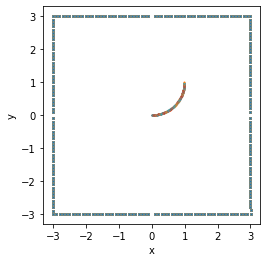

In [147]:
sub = plt.subplot()
sub.set_aspect('equal')
sub.set_xlabel('x')
sub.set_ylabel('y')

odometries, sensor_rs = read_lsc_file(filepath="circle2.lsc")

reference_scan = coord.robot2map(sensor_rs[0], odometries[0])
plot_scan(sub, reference_scan, odometries[0])

# robot_r = np.array([-1, -1, np.pi/8])
# plot_scan(coord.robot2map(sensor_r, odometory), sub)


# robot_r, icp_count, optimize_counts = icp(sensor_r, odometory, reference_scan, False)
# print(robot_r)
# print(np.sum(optimize_counts), optimize_counts)


robot_rs = []
reference_scans = []
optimize_counts = []
reference_scan = coord.robot2map(sensor_rs[0], odometries[0])
for i, (odometory, sensor_r) in enumerate(zip(odometries, sensor_rs)):
    robot_r, icp_count, optimize_count = icp(sensor_r, odometory, reference_scan, False)
    robot_rs.append(robot_r)
    optimize_counts.append(optimize_count)
    # print(robot_r)
    print(i, np.sum(optimize_count), optimize_count)
    # reference_scan = coord.robot2map(sensor_r, robot_r)
    reference_scans.append(reference_scan)
    plot_scan(sub, reference_scan, robot_r)

# np.array(reference_scans).shape

In [144]:
np.savez('normal', robot_r=np.array(robot_rs), optimize_count=np.array(optimize_counts), reference_scan=np.array(reference_scans))


In [4]:
def padding(optimize_counts):
    optimize_counts = list(map(lambda x: x.tolist(), optimize_counts.tolist()))
    l = max(map(len, optimize_counts))
    optimize_counts = list(map(lambda x: x + [0]*(l-len(x)), optimize_counts))
    return np.array(optimize_counts)

In [5]:
optimize_counts = np.load('normal.npz', allow_pickle=True)['optimize_count']
optimize_counts = padding(optimize_counts)
optimize_counts = np.sum(optimize_counts, axis=-1)
print(optimize_counts)
np.sum(optimize_counts)

[ 1  5  1  6  1  3  2  4  5  5  7  5  5  6  7  5  4  2  4  4  1  1  5  2
  5  3  2  2  4  1  1  4  5  5  6  8  4  7  8  8  9 10 10  9  9  8  9  9
  9  8  6  6  6  2  3  1  2  3  3  5  1  4  1  2  4  2  2  2  2  4  1  1
  1  1  1  1  4  2  1  4  6  6  6  7  6  7  8  8  9  7  6  4  3  4  3  1
  1  5  1  1  4  1  1  1  3  3  5  7  6  4  1  2  1  5  7  7  8  8  8  8
  8  9  7  7  7  6  4  5  3  2  1  4  1  3  1  1  1  2  2  5  2  1  3  4
  3  6  4  5  5  4  2  1  1  1  5  8  7  8  8  8  7  8  9  8  8  7  8  7
  7  5  6  6  8  8  8  8  8  8  7  5  1  4  4  1  1  4  5  6  7  6  6  7
  7  6  6  6  2  3  5  1]


920

In [6]:
optimize_counts_ref = np.load('ref.npz', allow_pickle=True)['optimize_count']
optimize_counts_ref = padding(optimize_counts_ref)
optimize_counts_ref = np.sum(optimize_counts_ref, axis=-1)
print(optimize_counts_ref)
np.sum(optimize_counts_ref)

[  1   5   1  24  12  11   9   5   9   8   9  20  22  24   9  15   6   4
  27   8   1   1   1   1   3   4   3  12  29  31  26   8  13  18  21  42
  32  48  56  58  62  62  62  64  65  69  65  70  69  70  64  59  49  52
  51  54  57  55  54  59  60  65  66  63  69  63  61  64  73  72  81  85
  79  78  79  74  77  74  68  76  77  77  79  76  78  79  82  87  91  90
  93  85  85  93  94  92  88  83  90  87  87  93  87  91  95  88  95  94
  90  89  98  98 101 101 101 100  99 104 108 115 111 103 102 105 102 105
 114 117 117 123 121 124 120 123 122 119 119 110 112 113 111 113 112 116
 111 115 109 106 103 104 104  98  93  86  89  92  86 100 102 100 101 104
 108 106  99  98  94  94  88  78  85  88  91  88  89  92  92  87  93  99
  96 110 114 104 101  96 101  86  87  95  87  78  74  78  84  89  89  90
  83  84]


14948

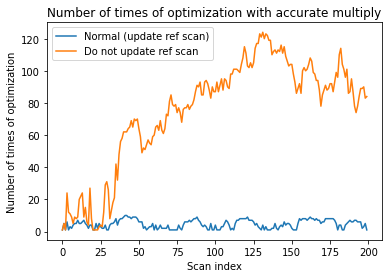

In [9]:
plt.plot(np.linspace(0, 199, 200), optimize_counts, label='Normal (update ref scan)')
plt.plot(np.linspace(0, 199, 200), optimize_counts_ref, label='Do not update ref scan')
plt.xlabel('Scan index')
plt.ylabel('Number of times of optimization')
plt.title('Number of times of optimization with accurate multiply')
plt.legend()

In [84]:
def get_robot_r(x, y):
    X, Y = np.meshgrid(x, y)
    xy = np.stack([X, Y], axis=2)
    t = np.array([[[robot_r[..., 2]]]*len(x)]*len(y))

    return np.concatenate([xy, t], axis=-1), X, Y

def plot_cost(X, Y, cost):
    fig = plt.figure(figsize=plt.figaspect(1))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("cost")
    ax.plot_wireframe(X, Y, cost)
    plt.show()


def plot_diff(X, Y, diff):
    sub = plt.subplot()
    sub.set_aspect('equal')
    sub.set_xlabel("X")
    sub.set_ylabel("Y")
    # sub.set_xlabel("Y")
    plt.quiver(X, Y, diff[..., 0], diff[..., 1])
    plt.show()

In [71]:
# x = np.linspace(-0.01, 0.025, 50)
# y = np.linspace(-0.02, 0.01, 50)
# x = np.linspace(-0.005, 0.02, 50)
# y = np.linspace(-0.015, 0.005, 50)

# x = np.linspace(0, 2, 25)
# y = np.linspace(0, 2, 25)

x = np.linspace(0.98, 1.01, 25)
y = np.linspace(0.98, 1.01, 25)

robot_rs, X, Y = get_robot_r(x, y)


[0.99205914 0.99139451 1.56462284]


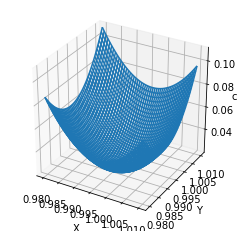

In [135]:
x = np.linspace(0.98, 1.01, 25)
y = np.linspace(0.98, 1.01, 25)

robot_rs, X, Y = get_robot_r(x, y)

print(robot_r)

cost = cost_function(sensor_r, robot_rs, reference_scan[closest_index])
plot_cost(X, Y, cost)

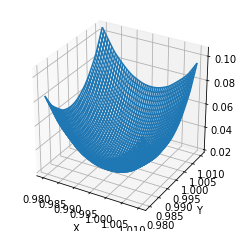

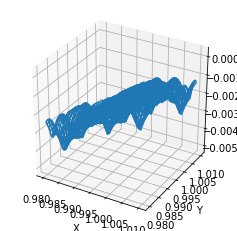

In [132]:
approx_cost = approx_cost_function(sensor_r, robot_rs, reference_scan[closest_index])

plot_cost(X, Y, approx_cost)
plot_cost(X, Y, approx_cost - cost)

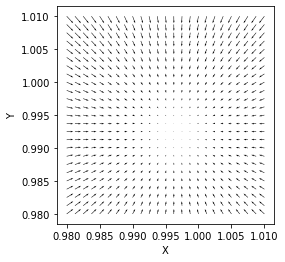

In [85]:

diff = -differential(sensor_r, robot_rs, reference_scan[closest_index])
plot_diff(X, Y, diff)

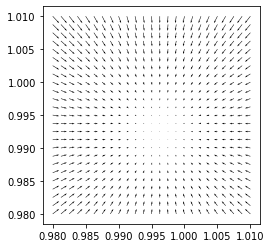

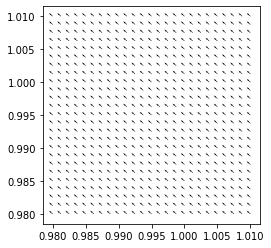

In [81]:
approx_diff = -approx_differential(sensor_r, robot_rs, reference_scan[closest_index])

plot_diff(X, Y, approx_diff)
plot_diff(X, Y, approx_diff - diff)